In [119]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
print('Shape of train :', train.shape, ' Shape of test : ', test.shape)

Shape of train : (1460, 81)  Shape of test :  (1459, 80)


In [3]:
train.head(3)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  

[3 rows x 81 columns]

In [4]:
test.head(2)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   

  LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence MiscFeature  \
0         Lvl    AllPub  ...         120        0    NaN  MnPrv         NaN   
1         Lvl    AllPub  ...           0        0    NaN    NaN        Gar2   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  
0       0      6    2010        WD         Normal  
1   12500      6    2010        WD         Normal  

[2 rows x 80 columns]

In [5]:
train_Id = train['Id']
test_Id = test['Id']
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

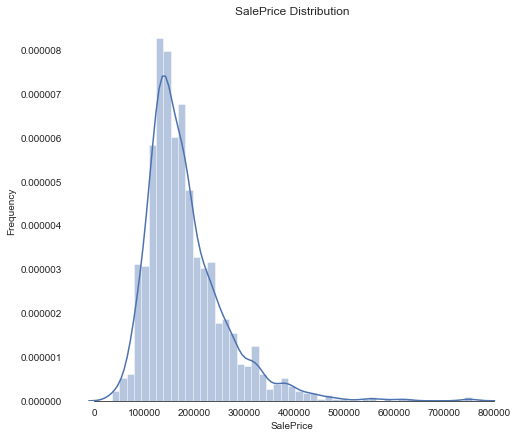

In [6]:
sns.set_style('white')
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))

sns.distplot(train['SalePrice'], color='b')
ax.xaxis.grid(False)
ax.set(ylabel='Frequency')
ax.set(xlabel='SalePrice')
ax.set(title='SalePrice Distribution')
sns.despine(trim=True, left=True)
plt.show()

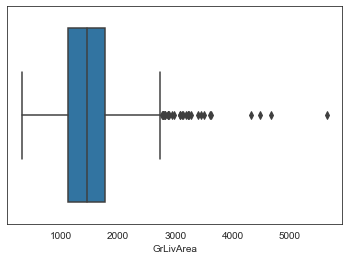

In [7]:
ax = sns.boxplot(x=train['GrLivArea'])

In [8]:
q4=train['GrLivArea'].quantile(1.)
q3=train['GrLivArea'].quantile(.75)
q2=train['GrLivArea'].quantile(.5)
q1=train['GrLivArea'].quantile(.25)
q0=train['GrLivArea'].quantile(0)
iqr=q3-q1 # interquartile range,IQR,四分位距
print('IQR:', iqr, '\nNorm:', q1-1.5*iqr, '~', q3+1.5*iqr)

IQR: 647.25 
Norm: 158.625 ~ 2747.625


In [9]:
train[train.GrLivArea > 4500]

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
523           60       RL        130.0    40094   Pave   NaN      IR1   
1298          60       RL        313.0    63887   Pave   NaN      IR3   

     LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
523          Bnk    AllPub    Inside  ...        0    NaN   NaN         NaN   
1298         Bnk    AllPub    Corner  ...      480     Gd   NaN         NaN   

     MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
523        0     10    2007       New        Partial     184750  
1298       0      1    2008       New        Partial     160000  

[2 rows x 80 columns]

In [10]:
train = train[train.GrLivArea < 4500]
train.reset_index(drop=True, inplace=True)  # 重新设置DataFrame的索引值

mu = 12.02 and sigma = 0.40


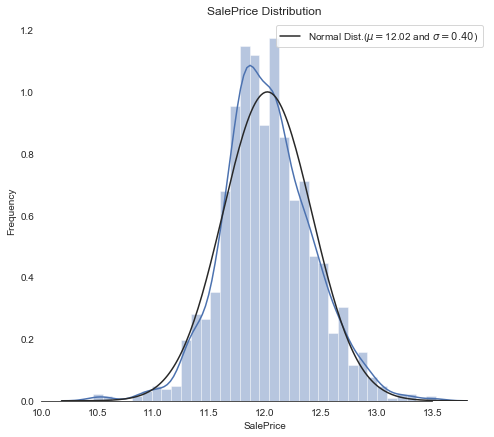

In [11]:
train['SalePrice'] = np.log1p(train['SalePrice'])
sns.set_style('white')
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
sns.distplot(train['SalePrice'], fit=norm, color='b')  # 绘制拟合黑线

(mu, sigma) = norm.fit(train['SalePrice'])
print('mu = {:.2f} and sigma = {:.2f}'.format(mu, sigma))

plt.legend(['Normal Dist.($\mu=${:.2f} and $\sigma={:.2f}$)'.format(mu, sigma)], loc='best')
ax.xaxis.grid(False)
ax.set(ylabel='Frequency')
ax.set(xlabel='SalePrice')
ax.set(title='SalePrice Distribution')
sns.despine(trim=True, left=True)
plt.show()

In [59]:
y = train.SalePrice.reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)
test_features = test

features = pd.concat([train_features, test_features]).reset_index(drop=True)
print('Feature Size:', features.shape)

Feature Size: (2917, 79)


In [ ]:
def precent_missing(df):
    data = pd.DataFrame(df)
    df_cols = list(df)
    dict_x = {}
    for i in range(0, len(df_cols)):
        dict_x.update({df_cols[i]: round(data[df_cols[i]].isnull().mean())})
    return dict_x

In [62]:
features['PoolQC'].isnull().mean()

0.9969146383270483

In [40]:
missing = precent_missing(features)
df_miss = sorted(missing.items(), key=lambda x:x[1], reverse=True)
print('Percent of Missing Data:')
df_miss[0:10]

Percent of Missing Data:


[('PoolQC', 99.69),
 ('MiscFeature', 96.4),
 ('Alley', 93.21),
 ('Fence', 80.43),
 ('FireplaceQu', 48.68),
 ('LotFrontage', 16.66),
 ('GarageYrBlt', 5.45),
 ('GarageFinish', 5.45),
 ('GarageQual', 5.45),
 ('GarageCond', 5.45)]

In [41]:
from pandas_profiling import ProfileReport

In [42]:
train_profile_report = ProfileReport(features, 'Data Set Profiling Report', html={'style':{'full_width':True}})

In [43]:
train_profile_report.to_notebook_iframe()

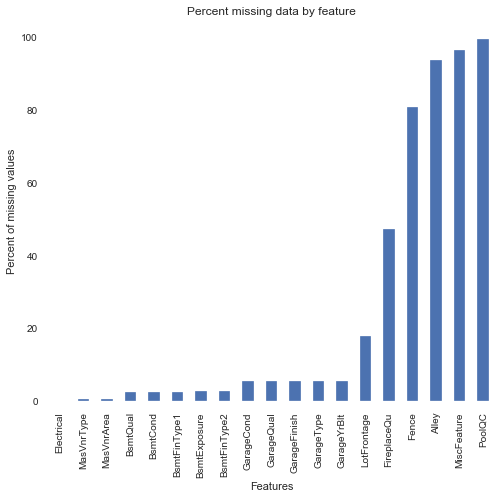

In [44]:
sns.set_style('white')
f, ax = plt.subplots(figsize=(8, 7))
sns.set_color_codes(palette='deep')
missing = round(train.isnull().mean()*100, 2)
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='b')

# Tweak the visual presentation
ax.xaxis.grid(False)
ax.set(ylabel="Percent of missing values")
ax.set(xlabel="Features")
ax.set(title="Percent missing data by feature")
sns.despine(trim=True, left=True)

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 80 columns):
MSSubClass       1458 non-null int64
MSZoning         1458 non-null object
LotFrontage      1199 non-null float64
LotArea          1458 non-null int64
Street           1458 non-null object
Alley            91 non-null object
LotShape         1458 non-null object
LandContour      1458 non-null object
Utilities        1458 non-null object
LotConfig        1458 non-null object
LandSlope        1458 non-null object
Neighborhood     1458 non-null object
Condition1       1458 non-null object
Condition2       1458 non-null object
BldgType         1458 non-null object
HouseStyle       1458 non-null object
OverallQual      1458 non-null int64
OverallCond      1458 non-null int64
YearBuilt        1458 non-null int64
YearRemodAdd     1458 non-null int64
RoofStyle        1458 non-null object
RoofMatl         1458 non-null object
Exterior1st      1458 non-null object
Exterior2nd      1458 non-

In [65]:
# 非数值特征存储转化为str，从Distinct count可以看出
features.MSSubClass = features.MSSubClass.apply(str)
features.YrSold = features.YrSold.apply(str)
features.MoSold = features.MoSold.apply(str)

# 分类使用众数填充缺失值
features.Functional = features.Functional.fillna(features.Functional.mode()[0])
features.Electrical = features.Electrical.fillna(features.Electrical.mode()[0])
features.KitchenQual = features.KitchenQual.fillna(features.KitchenQual.mode()[0])
features.Exterior1st = features.Exterior1st.fillna(features.Exterior1st.mode()[0])
features.Exterior2nd = features.Exterior2nd.fillna(features.Exterior2nd.mode()[0])
features.SaleType = features.SaleType.fillna(features.SaleType.mode()[0])

# 99%的没有pool，填充为None
features.PoolQC = features.PoolQC.fillna('None')
# 数据相关性 若没有车库，就不会有车以及车库面积
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    features[col] = features[col].fillna(0)

# 使用None替代缺失值
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    features[col] = features[col].fillna('None')

# 地下室相关Bsmt-(除去 BsmtFinSF1/BsmtFinSF2/BsmtFinSF)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('None')
# 分类填充
features.MSZoning = features.groupby('MSSubClass').MSZoning.transform(lambda x:x.fillna(x.mode()[0]))
features.LotFrontage = features.groupby('Neighborhood').LotFrontage.transform(lambda x: x.fillna(x.median()))
features.shape

(2917, 79)

In [27]:
features.KitchenQual.mode()

0    TA
dtype: object

In [24]:
features['KitchenQual'].mode()[0]

'TA'

In [35]:
features.groupby('MSSubClass')['MSZoning'].apply(lambda x: x.fillna(x.mode()[0]))

0       RL
1       RL
2       RL
3       RL
4       RL
        ..
2912    RM
2913    RM
2914    RL
2915    RL
2916    RL
Name: MSZoning, Length: 2917, dtype: object

In [36]:
features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

0       RL
1       RL
2       RL
3       RL
4       RL
        ..
2912    RM
2913    RM
2914    RL
2915    RL
2916    RL
Name: MSZoning, Length: 2917, dtype: object

In [66]:
# categorical features using 'None'
objects = []
for i in features.columns:
    if features[i].dtype == 'object':
        objects.append(i)
features.update(features[objects].fillna('None'))

In [67]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics.append(i)
features.update(features[numerics].fillna(0))

In [68]:
# Check the state of missing values
missing = precent_missing(features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:10]

Percent of missing data


[('MSSubClass', 0.0),
 ('MSZoning', 0.0),
 ('LotFrontage', 0.0),
 ('LotArea', 0.0),
 ('Street', 0.0),
 ('Alley', 0.0),
 ('LotShape', 0.0),
 ('LandContour', 0.0),
 ('Utilities', 0.0),
 ('LotConfig', 0.0)]

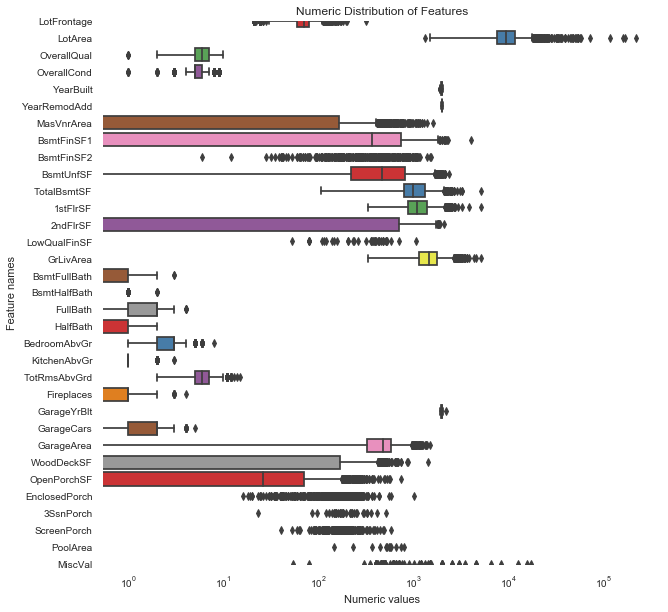

In [70]:
sns.set_style('white')
f, ax = plt.subplots(figsize=(10, 10))
ax.set_xscale('log')
ax = sns.boxplot(data=features[numerics], orient='h', palette='Set1')

ax.xaxis.grid(False)
ax.set(ylabel='Feature names')
ax.set(xlabel='Numeric values')
ax.set(title='Numeric Distribution of Features')
sns.despine(trim=True, left=True)

In [72]:
# 偏度较大的特征进行数据转换: 定义何为偏度较大
skew_features = features[numerics].apply(lambda x:skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index
print('There are {} numerical features with Skew > 0.5:'.format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew':high_skew})
skew_features.head(10)

There are 25 numerical features with Skew > 0.5:


MiscVal          21.939672
PoolArea         17.688664
LotArea          13.109495
LowQualFinSF     12.084539
3SsnPorch        11.372080
KitchenAbvGr      4.300550
BsmtFinSF2        4.144503
EnclosedPorch     4.002344
ScreenPorch       3.945101
BsmtHalfBath      3.929996
dtype: float64

In [75]:
#We use the numpy fuction log1p 
def show_skew(df):
    df = np.log1p(df)
    sns.set_style("white")
    sns.set_color_codes(palette='deep')
    f, ax = plt.subplots(figsize=(8, 7))
    #Check the new distribution 
    sns.distplot(df , fit=norm, color="b");

    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(df)
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

    #Now plot the distribution
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    ax.xaxis.grid(False)
    ax.set(ylabel="Frequency")
    ax.set(xlabel="MiscVal")
    ax.set(title="MiscVal distribution")
    sns.despine(trim=True, left=True)

    plt.show()


 mu = 0.04 and sigma = 0.20



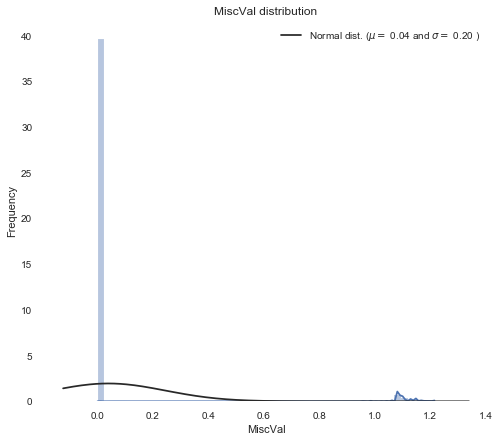

In [76]:
before_MiscVal = features['MiscVal']
show_skew(before_MiscVal)

In [77]:
after_MiscVal = boxcox1p(before_MiscVal, boxcox_normmax(before_MiscVal + 1))


 mu = 0.10 and sigma = 0.52



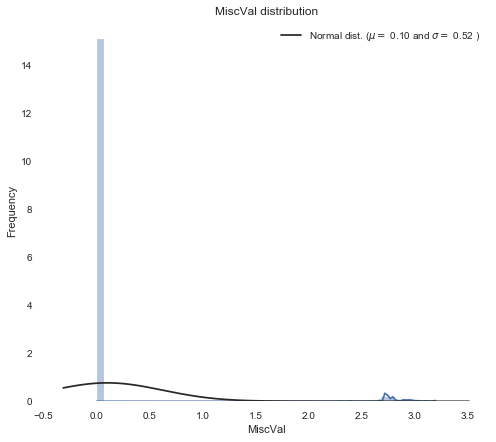

In [78]:
show_skew(after_MiscVal)

In [79]:
# Normalise skewed features
for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

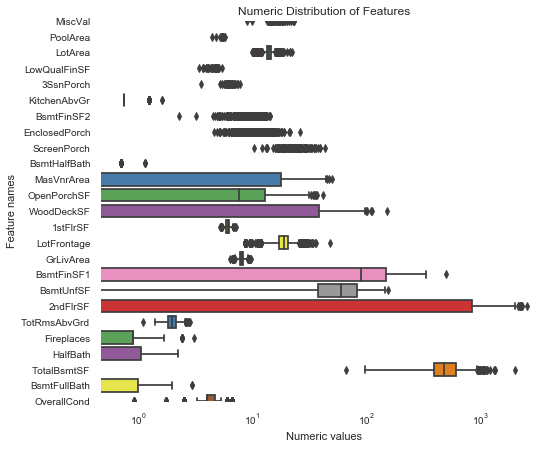

In [80]:
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=features[skew_index] , orient="h", palette="Set1")
# Tweak the visual presentation
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

In [83]:
features['TotalSF'] = features.TotalBsmtSF + features['1stFlrSF'] + features['2ndFlrSF']
features['Total_Bathrooms'] = features.FullBath + 0.5 * features.HalfBath + features.BsmtFullBath + 0.5 * features.BsmtHalfBath
features['Total_porch_sf'] = features.OpenPorchSF + features['3SsnPorch'] + features.EnclosedPorch + features.ScreenPorch + features.WoodDeckSF

In [84]:
features

MSSubClass MSZoning  LotFrontage    LotArea Street Alley LotShape  \
0            60       RL    18.144572  13.833055   Pave  None      Reg   
1            20       RL    20.673624  14.117919   Pave  None      Reg   
2            60       RL    18.668045  14.476514   Pave  None      IR1   
3            70       RL    17.249650  14.106198   Pave  None      IR1   
4            60       RL    21.314281  15.022009   Pave  None      IR1   
...         ...      ...          ...        ...    ...   ...      ...   
2912        160       RM     8.726308  10.765922   Pave  None      Reg   
2913        160       RM     8.726308  10.723224   Pave  None      Reg   
2914         20       RL    31.755368  15.820341   Pave  None      Reg   
2915         85       RL    17.611138  14.307160   Pave  None      Reg   
2916         60       RL    19.687481  14.124225   Pave  None      Reg   

     LandContour Utilities LotConfig  ...  Fence MiscFeature    MiscVal  \
0            Lvl    AllPub    Inside  ...   None        None   0.000000   
1            Lvl    AllPub       FR2  ...   None        None   0.000000   
2            Lvl    AllPub    Inside  ...   None        None   0.000000   
3            Lvl    AllPub    Corner  ...   None        None   0.000000   
4            Lvl    AllPub       FR2  ...   None        None   0.000000   
...          ...       ...       ...  ...    ...         ...        ...   
2912         Lvl    AllPub    Inside  ...   None        None   0.000000   
2913         Lvl    AllPub    Inside  ...   None        None   0.000000   
2914         Lvl    AllPub    Inside  ...   None        None   0.000000   
2915         Lvl    AllPub    Inside  ...  MnPrv        Shed  15.516254   
2916         Lvl    AllPub    Inside  ...   None        None   0.000000   

     MoSold YrSold SaleType  SaleCondition      TotalSF  Total_Bathrooms  \
0         2   2008       WD         Normal  1454.079346         3.527858   
1         5   2007       WD         Normal   600.123083         2.355448   
2         9   2008       WD         Normal  1496.594929         3.527858   
3         2   2006       WD        Abnorml  1289.359540         1.993440   
4        12   2008       WD         Normal  1824.495780         3.527858   
...     ...    ...      ...            ...          ...              ...   
2912      6   2006       WD         Normal   936.899134         1.534418   
2913      4   2006       WD        Abnorml   936.899134         1.534418   
2914      9   2006       WD        Abnorml   584.386119         1.993440   
2915      7   2006       WD         Normal   452.678915         1.355448   
2916     11   2006       WD         Normal  1700.557410         2.534418   

      Total_porch_sf  
0          12.080308  
1          56.184223  
2           9.901080  
3          24.986827  
4          56.517269  
...              ...  
2912        0.000000  
2913        7.267259  
2914       75.771208  
2915       32.297235  
2916       52.596579  

[2917 rows x 82 columns]

In [85]:
features['MasVnrArea']

0       19.433175
1        0.000000
2       17.768840
3        0.000000
4       25.404164
          ...    
2912     0.000000
2913     0.000000
2914     0.000000
2915     0.000000
2916    13.690162
Name: MasVnrArea, Length: 2917, dtype: float64

In [86]:
# 把不能正则化的数据删除，不能正则化的标准是，数据范围跨距太大
features = features.drop(['MasVnrArea', 'OpenPorchSF', 'WoodDeckSF', 'BsmtFinSF1', '2ndFlrSF'], axis=1)

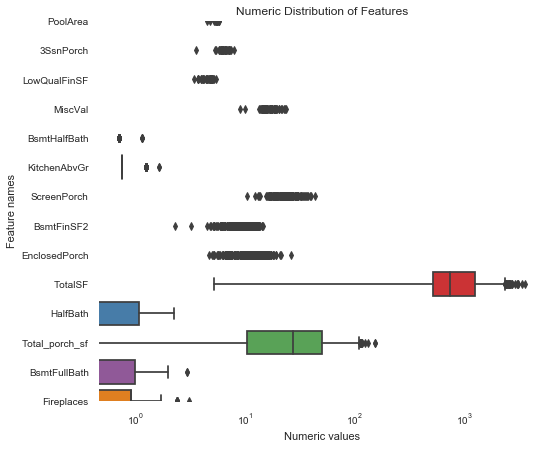

In [89]:
numerics = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics.append(i)
skew_features = features[numerics].apply(lambda x:skew(x)).sort_values(ascending=False)
high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

sns.set_style('white')
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale('log')
ax = sns.boxplot(data=features[skew_index], orient='h', palette='Set1')
# Tweak the visual presentation
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

In [93]:
## 添加一些简单特征
features['haspool'] = features.PoolArea.apply(lambda x:1 if x > 0 else 0)
features['hasgarage'] = features.GarageArea.apply(lambda x:1 if x>0 else 0)
features['hasbsmt'] = features.TotalBsmtSF.apply(lambda x:1 if x > 0 else 0)
features['hasfireplace'] = features.Fireplaces.apply(lambda x : 1 if x > 0 else 0)
features.shape

(2917, 81)

In [97]:
final_features = pd.get_dummies(features).reset_index(drop=True)  # 实现了one-hot编码
print(features.shape)
final_features.head()

(2917, 81)


LotFrontage    LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0    18.144572  13.833055            7     3.991517       2003          2003   
1    20.673624  14.117919            6     6.000033       1976          1976   
2    18.668045  14.476514            7     3.991517       2001          2002   
3    17.249650  14.106198            7     3.991517       1915          1970   
4    21.314281  15.022009            8     3.991517       2000          2000   

   BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  ...  SaleType_ConLw  \
0         0.0  29.991055   422.488453  5.939034  ...               0   
1         0.0  44.135414   593.888093  6.234990  ...               0   
2         0.0  56.896533   450.079655  5.994336  ...               0   
3         0.0  64.808855   378.854518  6.027704  ...               0   
4         0.0  61.166377   545.309850  6.161221  ...               0   

   SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0             0             0            1                      0   
1             0             0            1                      0   
2             0             0            1                      0   
3             0             0            1                      1   
4             0             0            1                      0   

   SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                      0                     0                     0   
1                      0                     0                     0   
2                      0                     0                     0   
3                      0                     0                     0   
4                      0                     0                     0   

   SaleCondition_Normal  SaleCondition_Partial  
0                     1                      0  
1                     1                      0  
2                     1                      0  
3                     0                      0  
4                     1                      0  

[5 rows x 334 columns]

In [99]:
X = final_features.iloc[:len(y), :]
X_test = final_features.iloc[len(X):, :]
print('Features size for train(X,y) and test(X_test):')
print('X:', X.shape, 'y', y.shape, 'X_test', X_test.shape)

Features size for train(X,y) and test(X_test):
X: (1458, 334) y (1458,) X_test (1459, 334)


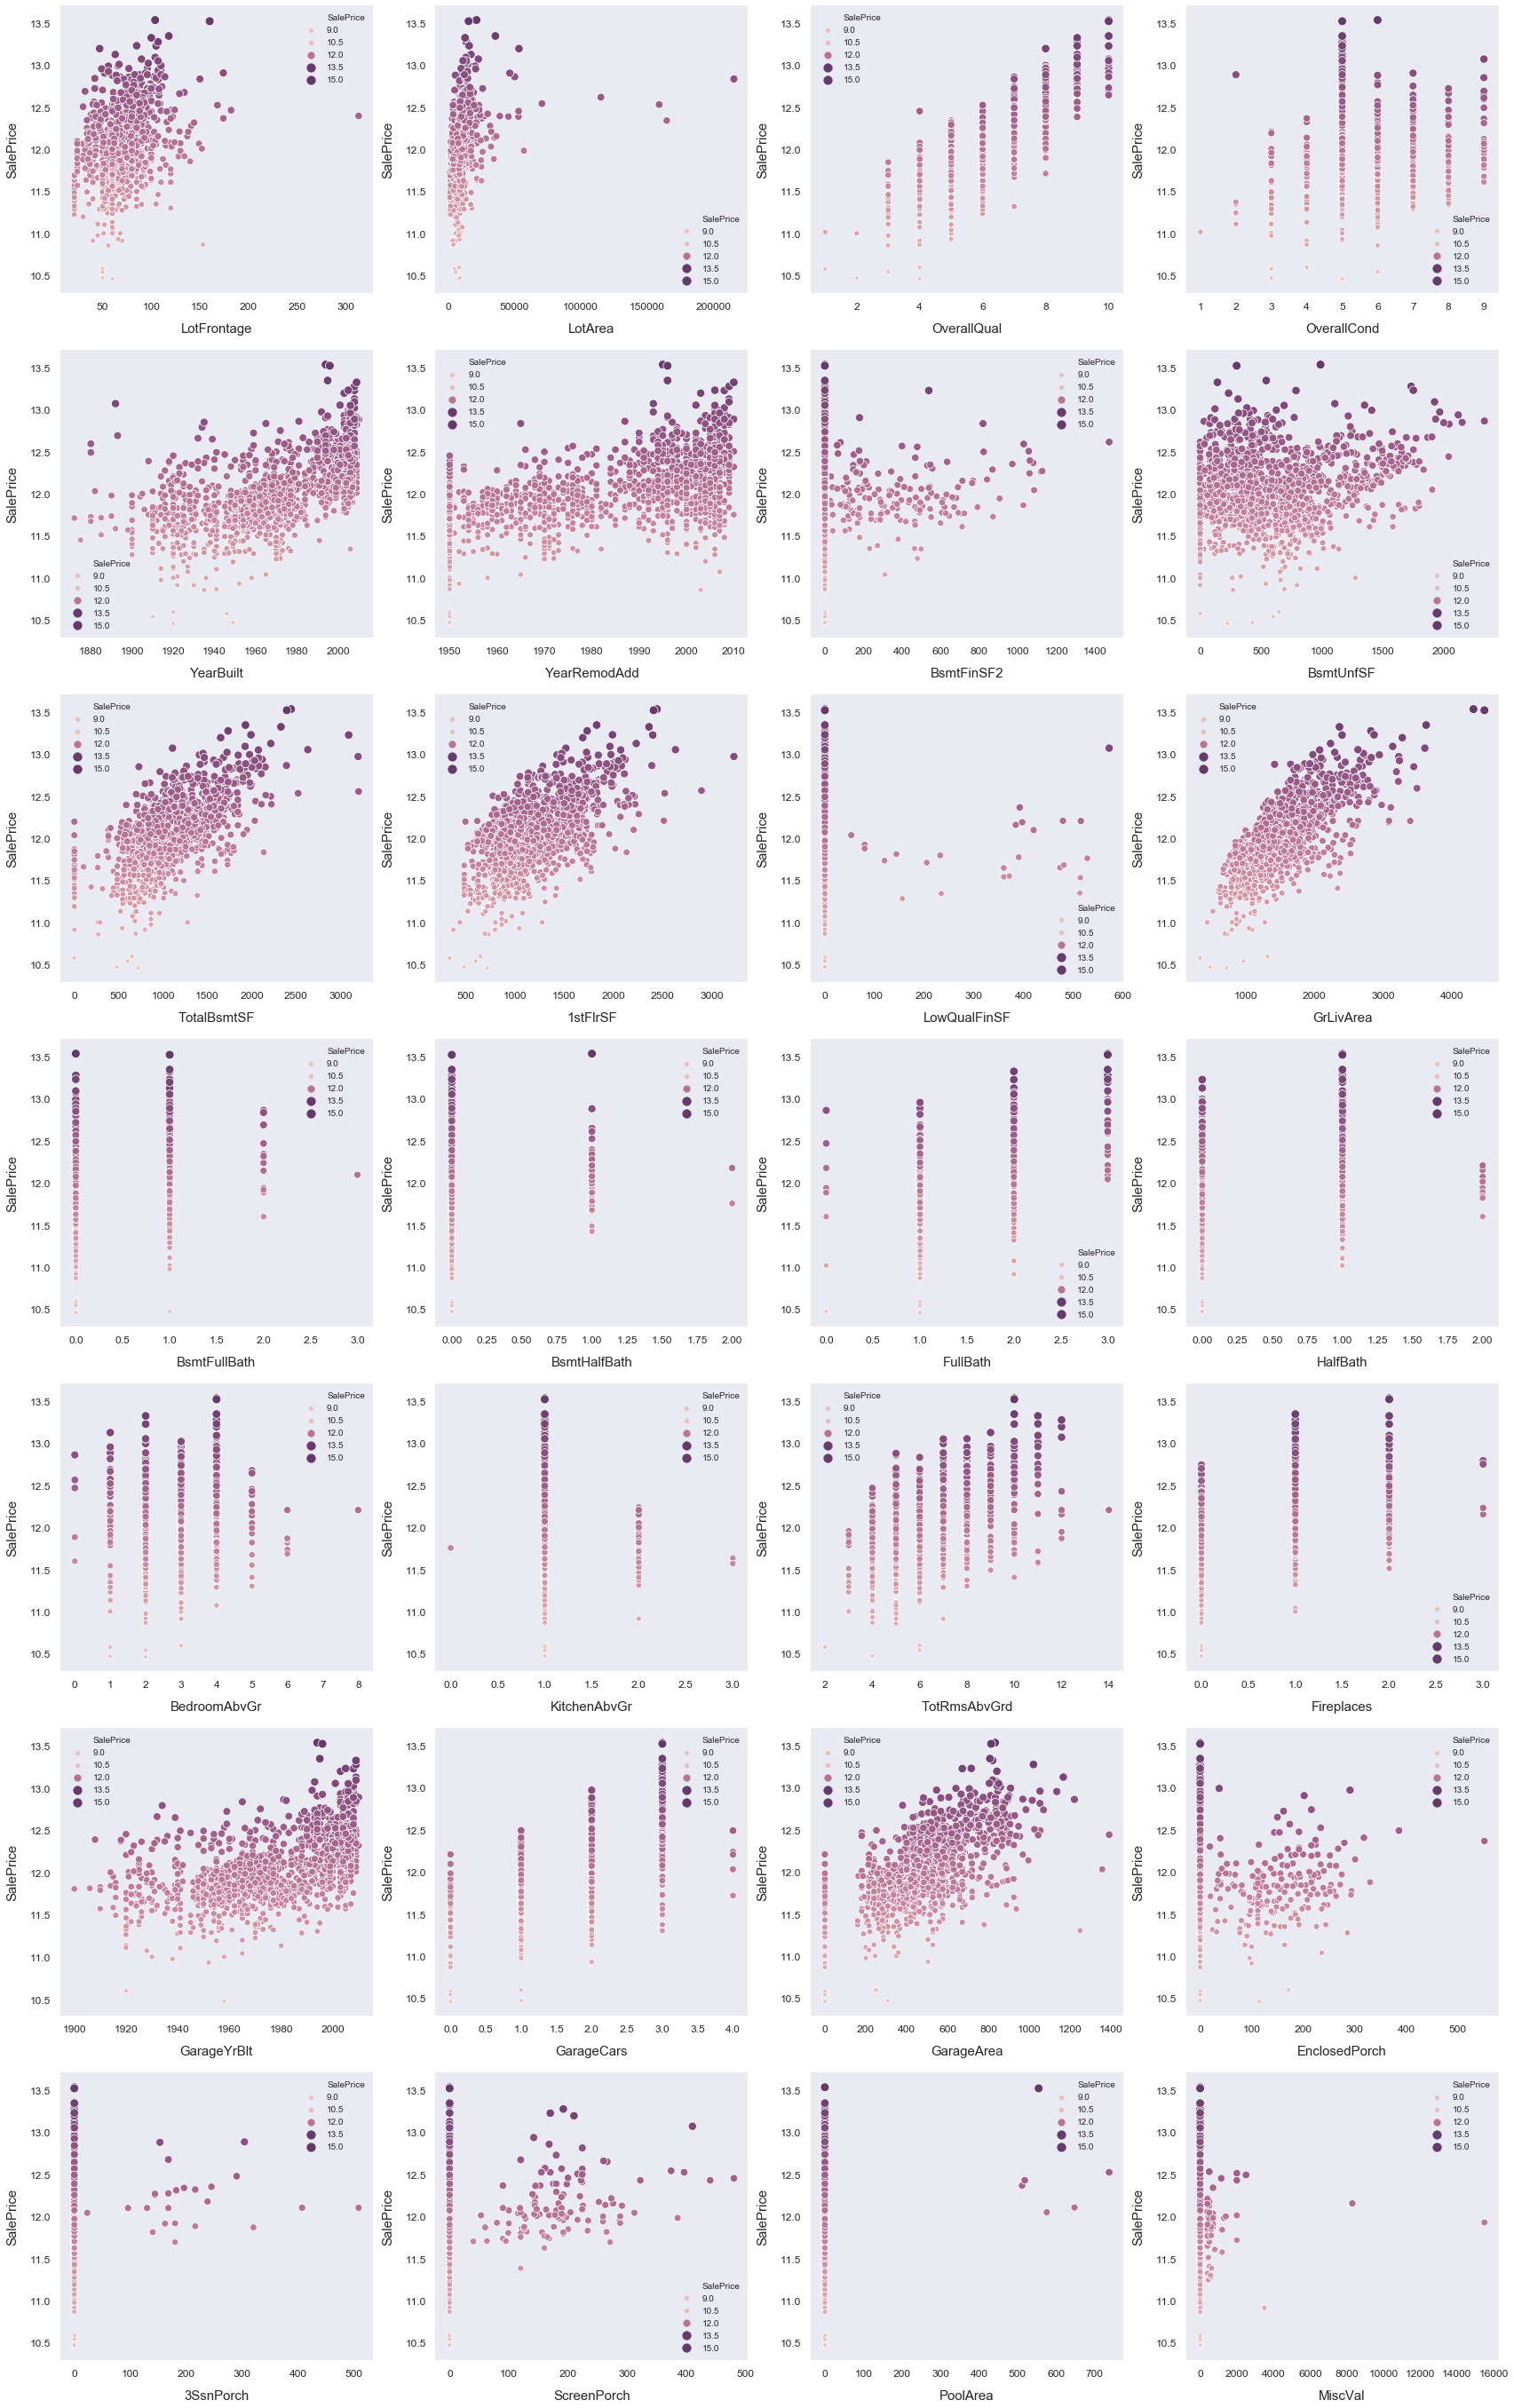

In [104]:
sns.set_style('dark')
numerics = []
for i in X.columns:
    if X[i].dtype in numeric_dtypes:
        if i in ['TotalSF', 'Total_Bathrooms', 'Total_porch_sf', 'haspool', 'hasgarage', 'hasbsmt', 'hasfireplace']:
            pass
        else:
            numerics.append(i)

            
fig, ax = plt.subplots(ncols=2, nrows=0, figsize=(12, 80))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)

cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)

for i, feature in enumerate(list(X[numerics]), 1): # 第二个参数表示索引的开始位置
    plt.subplot(len(list(numerics)), 4, i)
    sns.scatterplot(x=feature, y='SalePrice', hue='SalePrice', size='SalePrice', palette=cmap, data=train)
    plt.xlabel('{}'.format(feature), size=15, labelpad=12.5)
    plt.ylabel('SalePrice', size=15, labelpad=12.5)
    for j in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
    plt.legend(loc='best', prop={'size':10})
plt.show()

In [101]:
numerics

['LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal']

In [106]:
X[X.index==30]

LotFrontage    LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
30    15.362899  13.846156            4       3.2801       1920          1950   

    BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  ...  SaleType_ConLw  \
30         0.0  72.290797   331.363168  5.725305  ...               0   

    SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
30             0             0            1                      0   

    SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
30                      0                     0                     0   

    SaleCondition_Normal  SaleCondition_Partial  
30                     1                      0  

[1 rows x 334 columns]

In [110]:
# 删除zero的占比达到99.95的情况
overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.95:
        overfit.append(i)

overfit = list(overfit)
overfit.append('MSZoning_C (all)')
X = X.drop(overfit, axis=1).copy()
X_test = X_test.drop(overfit, axis=1).copy()

print('X', X.shape, 'y', y.shape, 'X_test', X_test.shape)

X (1458, 331) y (1458,) X_test (1459, 331)


In [111]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kfolds))  # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    return rmse

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [116]:
# Grid search CV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
param = {'alpha':[1.0,0.0,0.1,0.01,0.001, 0.0007]} 
model = Lasso()
grid_search = GridSearchCV(estimator=model, param_grid=param, cv=5) 
grid_search.fit(X, y)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

{'alpha': 0.0007}
Lasso(alpha=0.0007, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)


In [121]:
from sklearn.preprocessing import RobustScaler
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kfolds))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))
models = {
    'Ridge': ridge,
    'Lasso': lasso,
    'ElasticNet': elasticnet
}

predictions = {}
scores = {}
for name, model in models.items():
    model.fit(X, y)
    predictions[name] = np.expm1(model.predict(X))
    
    score = cv_rmse(model, X=X)
    scores[name] = (score.mean(), score.std())

In [122]:
print('------Score with CV_RMSLE------')
score = cv_rmse(ridge)
print('Ridge score:{:.4f}({:.4f})\n'.format(score.mean(), score.std()))

score = cv_rmse(lasso)
print('Lasso score: {:.4f}({:.4f})\n'.format(score.mean(), score.std()))

score = cv_rmse(elasticnet)
print('ElasticNet score: {:.4f}({:.4f})\n'.format(score.mean(), score.std()))

------Score with CV_RMSLE------
Ridge score:0.1097(0.0160)

Lasso score: 0.1098(0.0162)

ElasticNet score: 0.1097(0.0161)



In [123]:
scores

{'Ridge': (0.10967110139094438, 0.015998709848628064),
 'Lasso': (0.10977285364752945, 0.01615705092099839),
 'ElasticNet': (0.10973874048040715, 0.016113048234761687)}

In [124]:
#Fit the training data X, y
start = datetime.now()
print('Elasticnet')
elastic_model = elasticnet.fit(X, y)
print('Lasso')
lasso_model = lasso.fit(X, y)
print('Ridge')
ridge_model = ridge.fit(X, y)
print('All time:', datetime.now() - start)

Elasticnet
Lasso
Ridge
All time: 0:00:13.965352


In [125]:
def blend_models(X):
    return (elastic_model.predict(X) + lasso_model.predict(X) + ridge_model.predict(X)) / 3

blended_score = rmsle(y, blend_models(X))
print('RMSLE score on train data:')
print(rmsle(y, blend_models(X)))

RMSLE score on train data:
0.09397723033582628


In [133]:
predictions

{'Ridge': array([203770.49585012, 198038.4764761 , 214633.09704764, ...,
        259533.10180038, 143501.4511589 , 153872.1628239 ]),
 'Lasso': array([204149.75474523, 197989.12638562, 213521.87374164, ...,
        265548.91273093, 143593.16828005, 150645.19951898]),
 'ElasticNet': array([204103.23249676, 198061.57404045, 213836.10241598, ...,
        264893.99547247, 143029.50586312, 150911.91770587])}

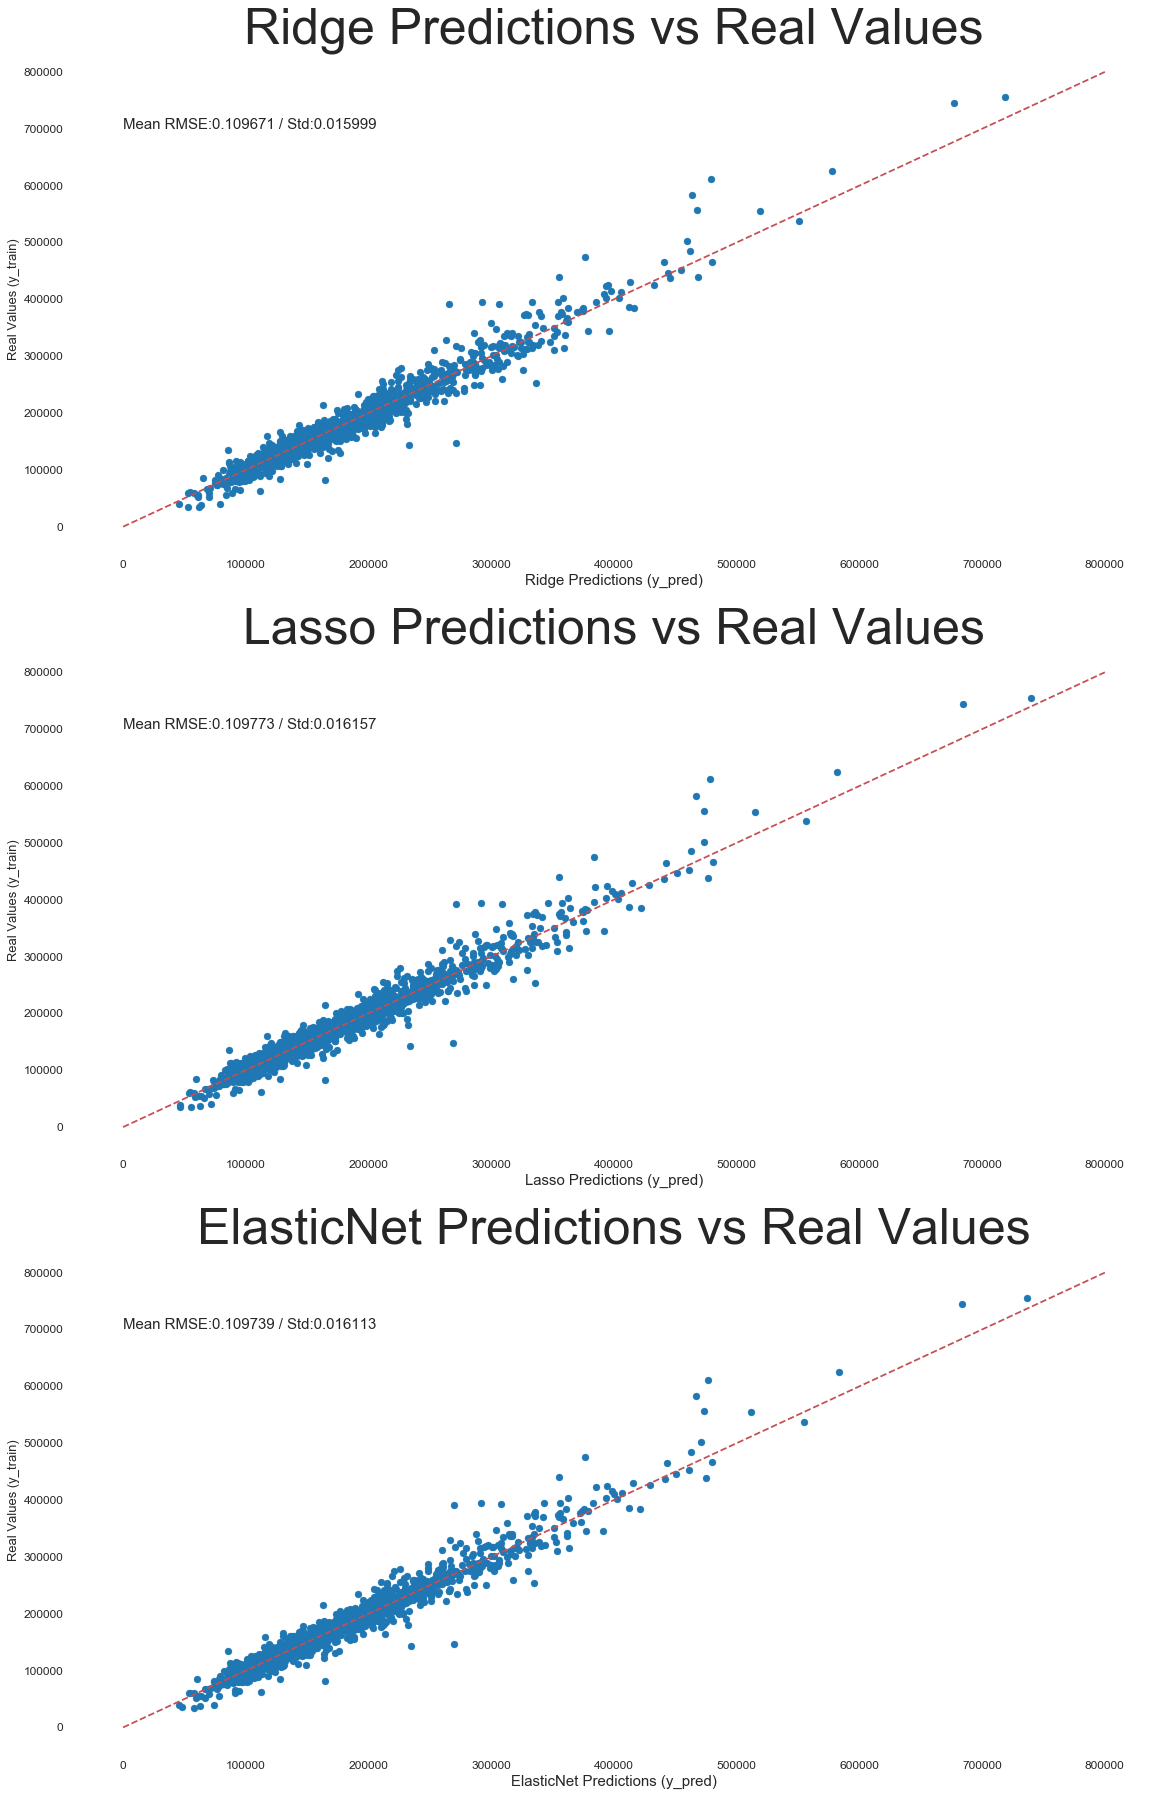

In [132]:
sns.set_style('white')
fig, axs = plt.subplots(ncols=0, nrows=3, figsize=(8,7))
plt.subplots_adjust(top=3.5, right=2)
for i, model in enumerate(models, 1):
    plt.subplot(3, 1, i)
    plt.scatter(predictions[model], np.expm1(y))  # 预测值和实际值
    plt.plot([0, 800000], [0, 800000], '--r')  # 手动辅助线，只有当预测值和实际值在x=y这条线上时，才会
    
    plt.xlabel('{} Predictions (y_pred)'.format(model), size=15)
    plt.ylabel('Real Values (y_train)', size=13)
    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)
    
    plt.title('{} Predictions vs Real Values'.format(model), size=50)
    plt.text(0, 700000, 'Mean RMSE:{:.6f} / Std:{:.6f}'.format(scores[model][0], scores[model][1]), fontsize=15)
    sns.despine(trim=True, left=True)
plt.show()

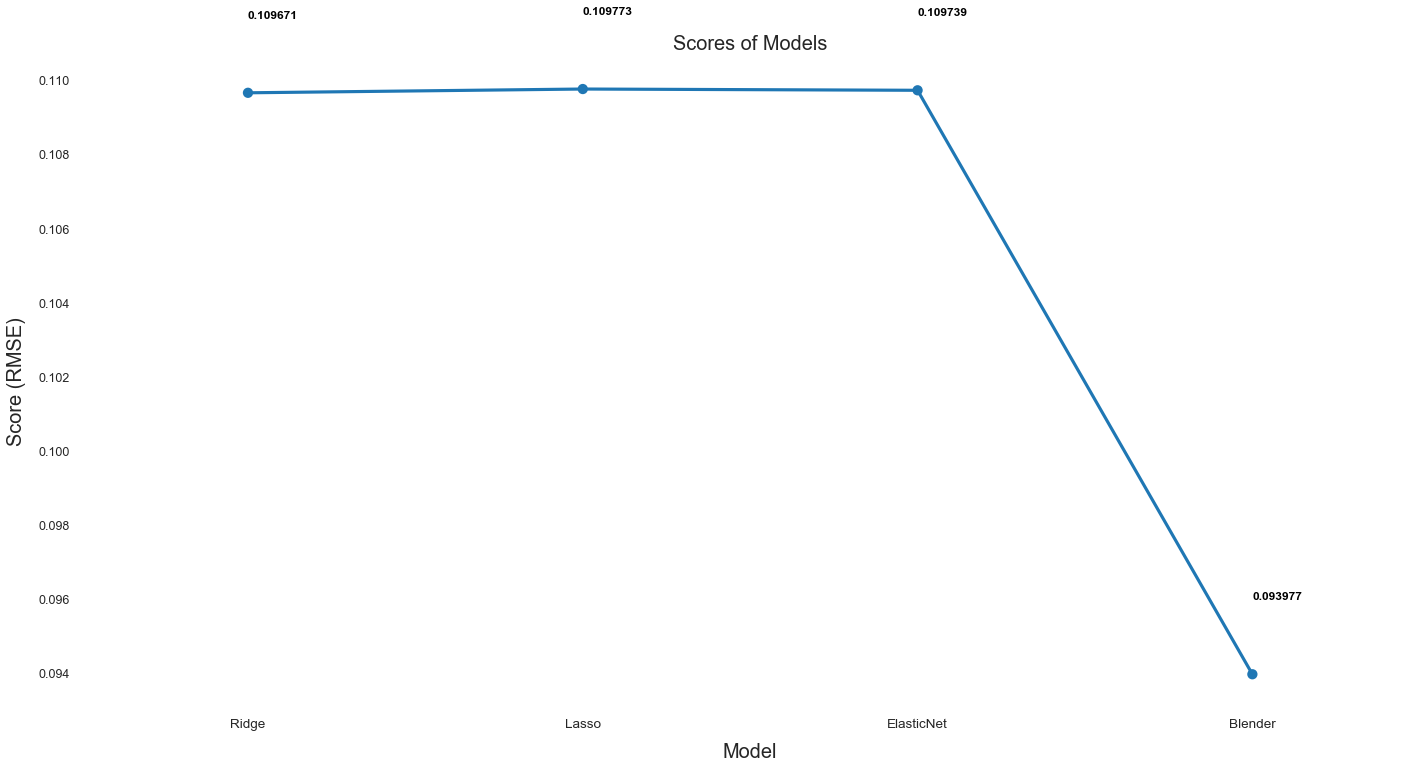

In [134]:
scores['Blender'] = (blended_score, 0)
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores of Models', size=20)

plt.show()

In [135]:
print('Predict submission')
y_test_r = pd.read_csv("data/sample_submission.csv")
submission = pd.read_csv("data/sample_submission.csv")
y_test = np.log1p(y_test_r.iloc[:,1].values)
submission.iloc[:,1] = np.expm1(blend_models(X_test))
blended_score = rmsle(y_test, blend_models(X_test))

Predict submission


In [136]:
submission.to_csv("new_submission.csv", index=False)

In [137]:
submission.head()

Id      SalePrice
0  1461  120332.943114
1  1462  157394.602467
2  1463  184688.905443
3  1464  202087.109137
4  1465  195573.673217